# test gunpowder predict/validation


In [7]:
from funlib.learn.torch.models import UNet, ConvPass
from gunpowder.torch import Train
import gunpowder as gp
import math
import numpy as np
import torch
import logging
import os
import sys
from tqdm import tqdm
from PIL import Image
from skimage import filters
import matplotlib.pyplot as plt
import zarr

logging.basicConfig(level=logging.INFO)

n_samples = 43

data_dir = "/mnt/efs/woods_hole/segmeNationData/Astro_data/"
val_data_dir = "/mnt/efs/woods_hole/segmeNationData/Astro_data/"

#def load_from_dir(dirname):
    #final = []
    #for fname in os.listdir(dirname):
    #im = Image.open(dirname) # os.path.join(dirname, fname))
    #imarray = np.array(im)
    #final.append(imarray)
        #return np.asarray(final) # shape = (60000,28,28)

#raw_data = load_from_dir(data_dir)

# Create some dummy "ground-truth" to train on:
#gt_data = filters.gaussian(raw_data[0], sigma=3.0)>0.1
#gt_data = gt_data[np.newaxis,:].astype(np.float32)

#print(np.shape(raw_data))
#print(np.shape(gt_data))

#plt.subplot(211)
#plt.imshow(np.squeeze(raw_data))

#plt.subplot(212)
#plt.imshow(np.squeeze(gt_data))
#plt.show()

#f = zarr.open('cortex.zarr', 'w')
#f['raw'] = raw_data
#f['raw'].attrs['resolution'] = (1, 1)
#f['ground_truth'] = gt_data
#f['ground_truth'].attrs['resolution'] = (1, 1)

zarr_name = "Astro_raw_gt_0.zarr"
zarr_path = os.path.join(data_dir, zarr_name)

val_zarr_name = "Astro_raw_gt_0.zarr"
val_zarr_path = os.path.join(val_data_dir, zarr_name)

log_dir = "logs"

# network parameters
num_fmaps = 32
input_shape = gp.Coordinate((196, 196))
output_shape = gp.Coordinate((156, 156))

batch_size = 32  # TODO: increase later

voxel_size = gp.Coordinate((1, 1))  # TODO: change later
input_size = input_shape * voxel_size
output_size = output_shape * voxel_size

checkpoint_every = 5000
train_until = 20000
snapshot_every = 1000
zarr_snapshot = False
num_workers = 11

# class WeightedMSELoss(torch.nn.MSELoss):

#     def __init__(self):
#         super(WeightedMSELoss, self).__init__()

#     def forward(self, prediction, gt, weights):

#         loss = super(WeightedMSELoss, self).forward(
#             prediction*weights,
#             gt*weights)

#         return loss


unet = UNet(
    in_channels=1,
    num_fmaps=num_fmaps,
    fmap_inc_factor=2,
    downsample_factors=[
        [2, 2],
        [2, 2],
    ],
    kernel_size_down=[[[3, 3], [3, 3]]]*3,
    kernel_size_up=[[[3, 3], [3, 3]]]*2,
    )
model = torch.nn.Sequential(
    unet,
    ConvPass(num_fmaps, 1, [[1, 1]], activation='Sigmoid'),
    )
#model = unet
# loss = WeightedMSELoss()
# loss = torch.nn.L1Loss()
loss = torch.nn.BCELoss()
# optimizer = torch.optim.Adam(lr=1e-5, params=model.parameters())
optimizer = torch.optim.Adam(lr=5e-5, params=model.parameters())


In [8]:
# helper function to show image(s), channels first
def imshow(raw, ground_truth=None, prediction=None):
  rows = 1
  if ground_truth is not None:
    rows += 1
  if prediction is not None:
    rows += 1
  cols = raw.shape[0] if len(raw.shape) > 3 else 1
  fig, axes = plt.subplots(rows, cols, figsize=(10, 4), sharex=True, sharey=True, squeeze=False)
  if len(raw.shape) == 3:
    axes[0][0].imshow(raw.transpose(1, 2, 0))
  else:
    for i, im in enumerate(raw):
      axes[0][i].imshow(im.transpose(1, 2, 0))
  row = 1
  if ground_truth is not None:
    if len(ground_truth.shape) == 3:
      axes[row][0].imshow(ground_truth[0])
    else:
      for i, gt in enumerate(ground_truth):
        axes[row][i].imshow(gt[0])
    row += 1
  if prediction is not None:
    if len(prediction.shape) == 3:
      axes[row][0].imshow(prediction[0])
    else:
      for i, gt in enumerate(prediction):
        axes[row][i].imshow(gt[0])
  plt.show()


In [9]:

raw = gp.ArrayKey('raw')
gt = gp.ArrayKey('gt')
predict = gp.ArrayKey('predict')
# gradients = gp.ArrayKey('GRADIENTS')

request = gp.BatchRequest()
request.add(raw, input_size)
request.add(gt, output_size)

snapshot_request = gp.BatchRequest()
snapshot_request[predict] = request[gt].copy()

sources = tuple(
    gp.ZarrSource(
        zarr_path,
        {
            raw: f'raw/{i}',
            gt: f'gt/{i}',
        },
        {
            raw: gp.ArraySpec(interpolatable=True, voxel_size=voxel_size),
            gt: gp.ArraySpec(interpolatable=False, voxel_size=voxel_size),
        }) +
    # gp.RandomLocation(min_masked=0.01, mask=fg_mask)
    gp.RandomLocation() +
    gp.Normalize(raw)
    # gp.Normalize(gt)
    for i in range(n_samples)
)

# raw:      (h, w)
# gt:   (h, w)

pipeline = sources
pipeline += gp.RandomProvider()
pipeline += gp.SimpleAugment()
pipeline += gp.ElasticAugment(
    # control_point_spacing=(64, 64),
    control_point_spacing=(48, 48),
    jitter_sigma=(5.0, 5.0),
    rotation_interval=(0, math.pi/2),
    subsample=4,
    )
pipeline += gp.IntensityAugment(
    raw,
    scale_min=0.8,
    scale_max=1.2,
    shift_min=-0.2,
    shift_max=0.2)
# pipeline += gp.NoiseAugment(raw, var=0.01)
# pipeline += gp.NoiseAugment(raw, var=0.001)
pipeline += gp.NoiseAugment(raw, var=0.01)

# raw:          (h, w)
# affinities:   (2, h, w)
# affs weights: (2, h, w)

# add "channel" dimensions
pipeline += gp.Unsqueeze([raw, gt])
# pipeline += gp.Unsqueeze([gt])

# raw:          (1, h, w)
# affinities:   (2, h, w)
# affs weights: (2, h, w)

# pipeline += gp.Squeeze([predict], axis=1)
pipeline += gp.Stack(batch_size)

# raw:          (b, 1, h, w)
# affinities:   (b, 2, h, w)
# affs weights: (b, 2, h, w)

pipeline += gp.PreCache(num_workers=num_workers)

pipeline += gp.Normalize(gt, factor=1)

pipeline += Train(
    model,
    loss,
    optimizer,
    inputs={
        'input': raw
    },
    outputs={
        0: predict,
    },
    #gradients={
    #    0: gradients
    #},
    loss_inputs={
        0: predict,
        1: gt,
    },
    log_dir = log_dir,
    save_every=1000)

#pipeline += gp.Squeeze([raw, gt], axis=1)
pipeline += gp.Squeeze([raw, gt, predict], axis=1)
pipeline += gp.Snapshot({
        gt: 'gt',
        predict: 'predict',
        raw: 'raw',
    },
    every=snapshot_every,
    # output_filename='batch_{iteration}.hdf',
    output_filename='batch_{iteration}.zarr' if zarr_snapshot else 'batch_{iteration}.hdf',
    additional_request=snapshot_request)

iterations = 10
with gp.build(pipeline):
    for i in tqdm(range(iterations)):
        pipeline.request_batch(request)



INFO:gunpowder.torch.nodes.train:Resuming training from iteration 20000
INFO:gunpowder.torch.nodes.train:Loading model_checkpoint_20000
INFO:gunpowder.torch.nodes.train:Using device cuda
  0%|                                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]INFO:gunpowder.nodes.precache:starting new set of workers (11, cache size 50)...
INFO:gunpowder.nodes.generic_train:Train process: iteration=20001 loss=0.226329 time=0.330129
INFO:gunpowder.nodes.snapshot:saving to snapshots/batch_20001.hdf
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.39it/s]INFO:gunpowder.producer_pool:terminating workers...
INFO:gunpowder.producer_pool:joining workers...
INFO:gunpowder.producer_pool:done



INFO:gunpowder.nodes.scan:scanning over 1 chunks
0it [00:00, ?it/s]INFO:gunpowder.nodes.scan:allocating array of shape (32, 1, 64, 64) for raw
INFO:gunpowder.nodes.scan:allocating array of shape (32, 1, 64, 64) for gt
1it [00:00,  2.21it/s]


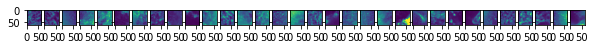

In [10]:
raw = gp.ArrayKey('raw')
gt = gp.ArrayKey('gt')
predict = gp.ArrayKey('predict')
# gradients = gp.ArrayKey('GRADIENTS')

request = gp.BatchRequest()
request.add(raw, input_size)
request.add(gt, output_size)

snapshot_request = gp.BatchRequest()
snapshot_request[predict] = request[gt].copy()

sources = tuple(
    gp.ZarrSource(
        zarr_path,
        {
            raw: f'raw/{i}',
            gt: f'gt/{i}',
        },
        {
            raw: gp.ArraySpec(interpolatable=True, voxel_size=voxel_size),
            gt: gp.ArraySpec(interpolatable=False, voxel_size=voxel_size),
        }) +
    # gp.RandomLocation(min_masked=0.01, mask=fg_mask)
    gp.RandomLocation() +
    gp.Normalize(raw)
    # gp.Normalize(gt)
    for i in range(n_samples)
)

# raw:      (h, w)
# gt:   (h, w)

pipeline = sources
pipeline += gp.RandomProvider()
# pipeline += gp.RandomProvider()

# raw:          (h, w)
# affinities:   (2, h, w)
# affs weights: (2, h, w)

# add "channel" dimensions
pipeline += gp.Unsqueeze([raw, gt])
# pipeline += gp.Unsqueeze([gt])

# raw:          (1, h, w)
# affinities:   (2, h, w)
# affs weights: (2, h, w)

# pipeline += gp.Squeeze([predict], axis=1)
pipeline += gp.Stack(batch_size)

# raw:          (b, 1, h, w)
# affinities:   (b, 2, h, w)
# affs weights: (b, 2, h, w)

request = gp.BatchRequest()
request[raw] = gp.Roi((0, 0), (64, 64))
request[gt] = gp.Roi((0, 0), (64, 64))
scan = gp.Scan(request)

pipeline += scan

with gp.build(pipeline):
    batch = pipeline.request_batch(request)

imshow(batch[raw].data, None,None)


INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 73.42it/s]


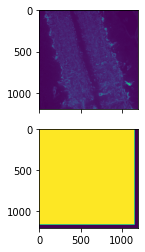

In [208]:
raw = gp.ArrayKey('val_raw')
gt = gp.ArrayKey('val_gt')
prediction = gp.ArrayKey('val_predict')
# gradients = gp.ArrayKey('GRADIENTS')

request = gp.BatchRequest()
request.add(raw, input_size)
request.add(gt, output_size)

snapshot_request = gp.BatchRequest()
snapshot_request[prediction] = request[gt].copy()

source = gp.ZarrSource(
        val_zarr_path,
        {
            raw: f'raw/1',
            gt: f'gt/1',
        },
        {
            raw: gp.ArraySpec(interpolatable=True, voxel_size=voxel_size),
            gt: gp.ArraySpec(interpolatable=False, voxel_size=voxel_size),
        })
    # gp.RandomLocation(min_masked=0.01, mask=fg_mask)
    # gp.RandomLocation() +
    # gp.Normalize(gt)

# raw:      (h, w)
# gt:   (h, w)

# normalize
normalize = gp.Normalize(raw) 

# unsqueeze
unsqueeze = gp.Unsqueeze([raw])

# set model into evaluation mode
model.eval()

predict = gp.torch.Predict(
  model,
  inputs = {
    'input': raw
  },
  outputs = {
    0: prediction
  })

stack = gp.Stack(1)

# request matching the model input and output sizes
scan_request = gp.BatchRequest()
scan_request[raw] = gp.Roi((0, 0), (196, 196))
scan_request[prediction] = gp.Roi((0, 0), (156, 156))

scan = gp.Scan(scan_request)

pipeline = (
  source +
  normalize +
  unsqueeze + 
  stack +
  predict +
  scan)

# request for raw and prediction for the whole image
request = gp.BatchRequest()
request[raw] = gp.Roi((0, 0), (1200, 1200))
request[prediction] = gp.Roi((0, 0), (1200, 1200))

with gp.build(pipeline):
  batch = pipeline.request_batch(request)

imshow(batch[raw].data, None, batch[prediction].data)


In [341]:
batch[prediction].data[0, 0:, 0][0, 1160:1170]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [14]:
def predict_single_image(val_zarr_path, file_ind, input_size, output_size, image_size, checkpoint=None):
    raw = gp.ArrayKey('val_raw')
    gt = gp.ArrayKey('val_gt')
    prediction = gp.ArrayKey('val_predict')
    # gradients = gp.ArrayKey('GRADIENTS')

    request = gp.BatchRequest()
    request.add(raw, input_size)
    request.add(gt, output_size)

    snapshot_request = gp.BatchRequest()
    snapshot_request[prediction] = request[gt].copy()

    source = gp.ZarrSource(
            val_zarr_path,
            {
                raw: f'raw/{file_ind}',
                gt: f'gt/{file_ind}',
            },
            {
                raw: gp.ArraySpec(interpolatable=True, voxel_size=voxel_size),
                gt: gp.ArraySpec(interpolatable=False, voxel_size=voxel_size),
            })

    # normalize
    normalize = gp.Normalize(raw) 

    # unsqueeze
    unsqueeze = gp.Unsqueeze([raw])

    # set model into evaluation mode
    model.eval()

    predict = gp.torch.Predict(
      model,
      inputs = {
        'input': raw
      },
      outputs = {
        0: prediction
      },
     checkpoint = checkpoint
    )

    stack = gp.Stack(1)

    # request matching the model input and output sizes
    scan_request = gp.BatchRequest()
    scan_request[raw] = gp.Roi((0, 0), input_size)
    scan_request[prediction] = gp.Roi((0, 0), output_size)

    scan = gp.Scan(scan_request)

    pipeline = (
      source +
      normalize +
      unsqueeze + 
      stack +
      predict +
      scan)

    # request for raw and prediction for the whole image
    request = gp.BatchRequest()
    request[raw] = gp.Roi((0, 0), image_size)
    # request[gt] = gp.Roi((0, 0), image_size)
    request[prediction] = gp.Roi((0, 0), image_size)

    with gp.build(pipeline):
        batch = pipeline.request_batch(request)

    # imshow(batch[raw].data, None, batch[prediction].data)
    return batch[prediction].data


In [15]:
from numcodecs import Blosc

# prediction on the whole dataset
def predict(test_zarr_path, predict_zarr_path, input_size, output_size, image_size, checkpoint=None):
    z = zarr.open(test_zarr_path)
    n_samples = len(z['raw'])
    
    print("Prediction and Writing to zarr...")
    compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)

    f = zarr.open(predict_zarr_path, 'a')

    for i in range(n_samples):
        file_ind = i
        prediction_i = predict_single_image(test_zarr_path, file_ind, input_size, output_size, image_size, checkpoint=checkpoint)
        f[f'predict/{i}'] = zarr.array(np.squeeze(prediction_i), compressor=compressor)
        
    print("Done!")
    

In [16]:
# validation on the whole dataset

def validate(val_zarr_path, input_size, output_size, image_size, loss_fn, metric_fn, checkpoint=None):
    z = zarr.open(val_zarr_path)
    n_samples = len(z['raw'])
    
    # print("Validate...")
    compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)
    
    val_loss = 0
    val_acc = 0
    n_skip_samples = 0
    d_size = (input_size[0] - output_size[0], input_size[1] - output_size[1])
    hd_size = (int((input_size[0] - output_size[0]) / 2), int((input_size[1] - output_size[1]) / 2))
    
    for i in range(n_samples):
        file_ind = i
        gt_i = z['gt'][f'{i}'][:]
        gt_i = gt_i[hd_size[0] : -hd_size[0], hd_size[1] : -hd_size[1]]
        
        prediction_i = predict_single_image(val_zarr_path, file_ind, input_size, output_size, image_size, checkpoint=checkpoint)
        prediction_i = np.squeeze(prediction_i)
        prediction_i = prediction_i[:-d_size[0], :-d_size[1]]
        
        val_loss += loss_fn(torch.tensor(prediction_i.astype(np.float64)), torch.tensor(gt_i.astype(np.float64)))
        val_acc_i = metric_fn(prediction_i > 0.5, gt_i > 0.)
        if np.isnan(val_acc_i):
            n_skip_samples += 1
        else:
            val_acc += val_acc_i
    
    val_loss /= n_samples
    val_acc /= (n_samples - n_skip_samples)
    
    return np.asscalar(val_loss.numpy()), val_acc
    

In [18]:
# test the prediction function
test_zarr_path = '/mnt/efs/woods_hole/segmeNationData/Astro_data/Astro_raw_gt_0.zarr'
predict_zarr_path = '/mnt/efs/woods_hole/segmeNationData/Astro_data/Astro_raw_gt_0_predict.zarr'
input_size = (196, 196)
output_size = (156, 156)
image_size = (1200, 1200)

predict(test_zarr_path, predict_zarr_path, input_size, output_size, image_size)


INFO:gunpowder.nodes.scan:scanning over 64 chunks


Prediction and Writing to zarr...


0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.59it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.89it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.72it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.89it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.82it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.12it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

Done!


In [20]:
# test the validation function
test_zarr_path = '/mnt/efs/woods_hole/segmeNationData/Astro_data/Astro_raw_gt_0.zarr'
# predict_zarr_path = '/mnt/efs/woods_hole/segmeNationData/Astro_data/Astro_raw_gt_0_predict.zarr'
input_size = (196, 196)
output_size = (156, 156)
image_size = (1200, 1200)
loss_fn = torch.nn.BCELoss()
metric_fn = lambda x, y: np.sum(np.logical_and(x, y)) / np.sum(np.logical_or(x, y))

validate(test_zarr_path, input_size, output_size, image_size, loss_fn, metric_fn)


INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.44it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.48it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.07it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.85it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.96it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.84it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

(0.24992354600568634, 0.3246285010057977)

In [267]:
file_ind = 0
gt_i = z['gt'][f'{file_ind}'][:]
prediction_i = predict_single_image(val_zarr_path, file_ind, input_size, output_size, image_size)

INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 73.42it/s]


In [21]:

print('Validate the model with the checkpoints...')
checkpoint_files = sorted(glob.glob('model_checkpoint_*'))
n_models = len(checkpoint_files)


val_arr = np.zeros((n_models, 3))
for i, ckpt_file in enumerate(checkpoint_files):
    val_loss, val_acc = validate(val_zarr_path, input_size, output_size, image_size, loss_fn, metric_fn, checkpoint=ckpt_file)
    step = float(ckpt_file.split('_')[-1])
    val_arr[i] = np.array([step, val_loss, val_acc])

val_arr = val_arr[val_arr[:, 0].argsort()]
print('Done!')

# pick the best model and predict on test images
best_ind = np.argmax(val_arr[:, 2])
best_ckpt_file = 'model_checkpoint_{}'.format(int(val_arr[best_ind, 0]))
print('The best model is on step {}'.format(val_arr[best_ind, 0]))
predict(test_zarr_path, predict_zarr_path, input_size, output_size, image_size, best_ckpt_file)


INFO:gunpowder.nodes.scan:scanning over 64 chunks


Validate the model with the checkpoints...


0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.46it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.38it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 70.69it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 70.97it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.83it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.85it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1,

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.80it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.47it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.93it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.35it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.15it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.02it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.65it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.99it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.27it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.01it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.97it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.42it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.03it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.77it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.56it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 67.78it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.70it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.34it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.43it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.27it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.75it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.91it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.22it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.01it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.62it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.81it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 70.35it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 70.25it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.77it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.20it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.79it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 70.16it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 70.82it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 73.41it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.89it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 73.68it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.65it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.31it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.31it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.73it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.83it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.38it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 69.08it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 70.98it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.48it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 67.06it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 70.96it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.12it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.52it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 70.11it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.12it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 70.23it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 65.38it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 65.36it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.30it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.94it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.93it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 74.85it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 73.31it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 74.41it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 73.02it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.83it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.53it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 68.74it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 70.17it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.34it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 74.08it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 74.29it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 74.29it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 74.22it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 74.73it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 73.90it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 75.13it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 74.36it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 74.14it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 74.31it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 69.25it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 73.50it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 74.39it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 74.10it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 73.80it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.49it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 70.16it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.63it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.57it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.52it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.38it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.58it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.16it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.65it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.88it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.74it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.42it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.40it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.31it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.53it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks


Done!
The best model is on step 18000.0
Prediction and Writing to zarr...


0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.02it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.68it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.74it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.16it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 72.05it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Predicting on gpu
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_raw
INFO:gunpowder.nodes.scan:allocating array of shape (1, 1, 1200, 1200) for val_predict
64it [00:00, 71.72it/s]
INFO:gunpowder.nodes.scan:scanning over 64 chunks
0it [00:00, ?it/s]INFO:gunpowder.torch.nodes.predict:Pr

Done!


In [4]:
import glob
print('Validate the model with the checkpoints...')
checkpoint_files = sorted(glob.glob('model_checkpoint_*'))
checkpoint_files

Validate the model with the checkpoints...


['model_checkpoint_1000',
 'model_checkpoint_10000',
 'model_checkpoint_11000',
 'model_checkpoint_12000',
 'model_checkpoint_13000',
 'model_checkpoint_14000',
 'model_checkpoint_15000',
 'model_checkpoint_16000',
 'model_checkpoint_17000',
 'model_checkpoint_18000',
 'model_checkpoint_19000',
 'model_checkpoint_2000',
 'model_checkpoint_20000',
 'model_checkpoint_3000',
 'model_checkpoint_4000',
 'model_checkpoint_5000',
 'model_checkpoint_6000',
 'model_checkpoint_7000',
 'model_checkpoint_8000',
 'model_checkpoint_9000']

In [6]:
!ls /mnt/efs/woods_hole/segmeNationData/Astro_data/Astro_raw_gt_0.zarr/raw/0/


0.0  0.1  1.0  1.1  2.0  2.1  3.0  3.1


In [112]:
# implement prediction/validation from scratch

raw_files = [val_zarr_path + f'/raw/{i}' for i in range(n_samples)]
gt_files = [val_zarr_path + f'/gt/{i}' for i in range(n_samples)]

In [114]:
x_val = list(map(z))

['/mnt/efs/woods_hole/segmeNationData/Astro_data/Astro_raw_gt_0.zarr/gt/0',
 '/mnt/efs/woods_hole/segmeNationData/Astro_data/Astro_raw_gt_0.zarr/gt/1',
 '/mnt/efs/woods_hole/segmeNationData/Astro_data/Astro_raw_gt_0.zarr/gt/2',
 '/mnt/efs/woods_hole/segmeNationData/Astro_data/Astro_raw_gt_0.zarr/gt/3',
 '/mnt/efs/woods_hole/segmeNationData/Astro_data/Astro_raw_gt_0.zarr/gt/4',
 '/mnt/efs/woods_hole/segmeNationData/Astro_data/Astro_raw_gt_0.zarr/gt/5',
 '/mnt/efs/woods_hole/segmeNationData/Astro_data/Astro_raw_gt_0.zarr/gt/6',
 '/mnt/efs/woods_hole/segmeNationData/Astro_data/Astro_raw_gt_0.zarr/gt/7',
 '/mnt/efs/woods_hole/segmeNationData/Astro_data/Astro_raw_gt_0.zarr/gt/8',
 '/mnt/efs/woods_hole/segmeNationData/Astro_data/Astro_raw_gt_0.zarr/gt/9',
 '/mnt/efs/woods_hole/segmeNationData/Astro_data/Astro_raw_gt_0.zarr/gt/10',
 '/mnt/efs/woods_hole/segmeNationData/Astro_data/Astro_raw_gt_0.zarr/gt/11',
 '/mnt/efs/woods_hole/segmeNationData/Astro_data/Astro_raw_gt_0.zarr/gt/12',
 '/mnt/ef

In [150]:
z = zarr.open(val_zarr_path)

X_val = [z['raw'][f'{i}'][:] for i in range(n_samples)]
Y_val = [z['gt'][f'{i}'][:] for i in range(n_samples)]

In [152]:
X_val = np.array(X_val)
Y_val = np.array(Y_val)


In [153]:
sz = X_val.shape[1:]


In [161]:
border = np.array((20., 20.))
out_size = np.array([156, 156])

In [217]:
len(z['raw'])

43

In [2]:
float('1223')

1223.0